Simulation, allowing us to validate our models describing how different behaviors are encoded in neural activity.  

In particular, these models are designed to describe how a preceeding behavior and succeeding behavior (e.g., behaviors observed before and after optogenetic stimulation is applied) are both encoded in neural activity at any point in time.  

We simulate data with a particular eye to the challenges that arise in our experimental setting.  These are: 

    1) We may only record from individual subjects performing one of the possible set of preceeding behaviors
    
    2) Each subject may only record a subset of the possible succeeding behaviors
    
    3) Neural activity recorded from individual subjects may have subject-specific offsets
    
    4) There is also noise in the recorded neural activity

We simulate ground-truth data from models of the following form: $y^s_e = c^\text{before}_e + c^\text{after}_e + \text{ref} + o^s + \epsilon^s_e$, where: $y^s_e$ is recorded neural activity subject $s$ and event $e$, $\text{ref}$ is the baseline neural activity for the "reference" condition (nominally Quiet -> Quiet), $c^\text{before}_e$ and $c^\text{after}_e$ are changes in neural activity if the preceding behavior or succeeding behaviors are non-quiet (there are specific coefficients for each different non-quiet behavior), $o^s$ is subject specific offset and $\epsilon^s_e$ is noise.

We seek to learn the values of $c^\text{before}_e$ and $c^\text{after}_e$ for all non-quiet behaviors and to determine when they are significantly different than zero. To do this, we fit models of the following form $y^s_e = c^\text{before}_e + c^\text{after}_e + \text{ref} + \epsilon_e^s$, where we have dropped the subject-specific offsets.  The reason for this is we are unable to identify them, and as long as they are not correlated with the behaviors we observe in each subject, they essentially just add more noise to the problem. 

Below we simulate data and fit models and then plot the 95% confidence intervals of the different behavior coefficients and compare these to the ground-truth values.  We want to see that most of the time the 95% confidence intrvals contain the true values.  We use statistical methods that take into account that we see non-independent observations from each subject (due to the subject specific offset). 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from janelia_core.stats.regression import grouped_linear_regression_ols_estimator
from janelia_core.stats.regression import grouped_linear_regression_acm_stats
from janelia_core.stats.regression import visualize_coefficient_stats

## Parameters go here 

In [3]:
# Specify the mean value of the ref, Q->Q, transition
ref_coef = .2

# Specify the before behaviors and how they are encoded in DFF relative to the ref condition
before_behs = ['F', 'B', 'H']
before_coefs = [.3, .1, 0.0]

# Specify the after behaviors and how they are encoded in DFF relative to the ref condition
after_behs = ['F', 'B', 'H']
after_coefs = [.7, .3, .5]

# Specify the standard deviation of subject-specific offsets 
subj_offset_std = .5

# Specify the range that noise standard deviations can take on for different subjects
subj_noise_std_range = [.2, .5]

# Specify the range of number of events we see per subject.  Bounds are inclusive. 
subj_n_events_range = [5, 10]

# Specify the max number of different after behaviors we can see per subject
subj_max_n_after_behs = 2

# Specify the number of subjects we record from
n_subjs = 250

# Alpha value for statistical testing
alpha = .05

## Generate data 

In [4]:
subj_noise_std_span = subj_noise_std_range[1] - subj_noise_std_range[0]
n_before_behs = len(before_behs) + 1
n_after_behs = len(before_behs) + 1

In [5]:
x = []
y = []
g = []
for s_n in range(n_subjs):
    
    # Pick the subject-specific offset for this subject
    subj_offset = subj_offset_std*np.random.randn(1)
    
    # Pick the subject-specific noise std for this subject 
    subj_noise_std = subj_noise_std_span*np.random.rand(1) + subj_noise_std_range[0]
    
    # Pick the preceeding behavior - we simulate things so that all subjects have a single class of preceeding 
    # behavior.  
    before_index = np.random.randint(n_before_behs)
    if before_index == 0:
        before_beh = 'Q'
        before_coef = 0.0
    else:
        before_beh = before_behs[before_index-1]
        before_coef = before_coefs[before_index-1]
    
    # Pick the subset of after behaviors we observe for this subject
    n_subj_after_behs = np.random.randint(subj_max_n_after_behs) + 1
    after_beh_inds = np.random.choice(n_after_behs, n_subj_after_behs, replace=False)
    
    # Pick the number of events we see for this subject 
    n_events = np.random.randint(low=subj_n_events_range[0], high=subj_n_events_range[1]+1, size=1)[0]
    

    # Generate x, y and g data for this subject:
    #     x is a 1-hot encoding of the behavior for an event
    #     y is the recorded dff for an event
    #     g is the id of the subject 
    
    subj_y = np.zeros(n_events)
    subj_x = np.zeros([n_events, n_before_behs + n_after_behs - 2]) # -2 because we don't encode quiet behaviors 
    subj_g = s_n + np.ones(n_events)
    for e_i in range(n_events):
        
        # Encode the before behavior
        if before_index > 0:
            subj_x[e_i, before_index-1] = 1
        
        # Pick the after behavior for this event 
        after_index = after_beh_inds[np.random.choice(len(after_beh_inds))]
        if after_index == 0:
            after_beh = 'Q'
            after_coef = 0.0
        else:
            after_beh = after_behs[after_index-1]
            after_coef = after_coefs[after_index-1]
            subj_x[e_i, n_before_behs + after_index - 2] = 1
            
        # Generate simulated dff for this event 
        subj_y[e_i] = ref_coef + before_coef + after_coef + subj_offset + subj_noise_std*np.random.randn(1)
        
    # Append data for this subject to our collection
    y.append(subj_y)
    x.append(subj_x)
    g.append(subj_g)
    
# Put all of our data for all subjects into single numpy arrays
y = np.concatenate(y, axis=0)
x = np.concatenate(x, axis=0)
g = np.concatenate(g, axis=0)

## Run statistics 

In [6]:
# Add offset term to x
x = np.concatenate([x, np.ones([x.shape[0], 1])], axis=1)

# Fit models
beta, acm, n_gprs = grouped_linear_regression_ols_estimator(x=x, y=y, g=g)

# Calculate statistics
mdl_stats = grouped_linear_regression_acm_stats(beta=beta, acm=acm, n_grps=n_gprs, alpha=alpha)

## Visualize results

The dots indicate the true coefficient values, whereas the error bars indicate the 95% confidence intervals from the modeling results

In [7]:
var_strs = ['before_' + beh for beh in before_behs] + ['after_' + beh for beh in after_behs] + ['QQ']

In [8]:
true_beta = np.asarray(before_coefs + after_coefs + [ref_coef])

<AxesSubplot:>

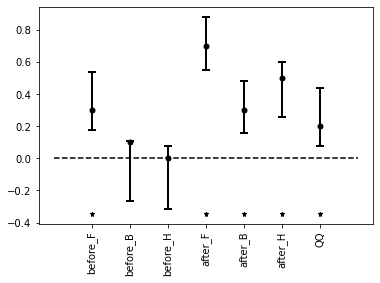

In [9]:
visualize_coefficient_stats(var_strs=var_strs, theta=true_beta, c_ints=mdl_stats['c_ints'], 
                            sig=mdl_stats['non_zero'], x_axis_rot=90)